In [27]:
import warnings
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore", category=UserWarning, module='keras.src.trainers.data_adapters.py_dataset_adapter')

import keras
import numpy as np

from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from keras.models import Model # type: ignore
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # type: ignore

from sklearn.utils.class_weight import compute_class_weight

In [28]:
dataset_path = 'Dataset'

In [29]:
train_val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,   
    validation_split=0.2 
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_val_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='binary',    
    subset='training',     
    shuffle=True
)

validation_generator = train_val_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='binary',    
    subset='validation',   
    shuffle=True
)

Found 4686 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [30]:
def build_cnn():
    input_layer = Input(shape=(224, 224, 3))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [31]:
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

class_counts = np.bincount(train_generator.classes)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))  

In [32]:
model = build_cnn()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    'models/best_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min'
)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.0001
)


In [33]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 267ms/step - accuracy: 0.7604 - loss: 3.9118 - val_accuracy: 0.7299 - val_loss: 52.2408
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 37s 251ms/step - accuracy: 0.8656 - loss: 0.8851 - val_accuracy: 0.7299 - val_loss: 4.5142
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 32s 217ms/step - accuracy: 0.8864 - loss: 0.4706 - val_accuracy: 0.7299 - val_loss: 9.8635
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 233ms/step - accuracy: 0.9197 - loss: 0.2687 - val_accuracy: 0.7299 - val_loss: 17.4059
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 33s 223ms/step - accuracy: 0.9115 - loss: 0.3214 - val_accuracy: 0.7496 - val_loss: 1.6359
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 36s 244ms/step - accuracy: 0.9236 - loss: 0.2317 - val_accuracy: 0.8949 - val_loss: 0.2457
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - accuracy: 0.9418 - loss: 0.1677 - val_accuracy: 0.8282 - val_loss: 0.3331
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 238ms/step - accuracy: 0.9290

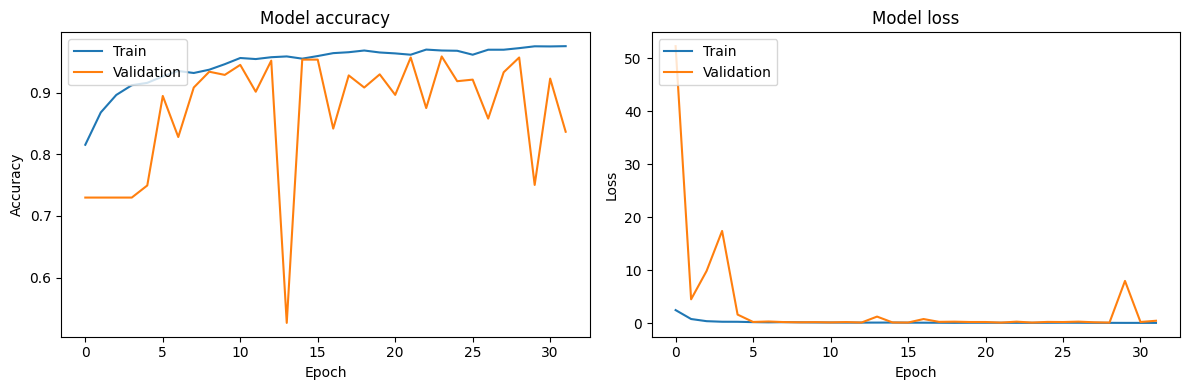

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [35]:
test_loss, test_accuracy = model.evaluate(validation_generator)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.9590 - loss: 0.1236
Test Loss: 0.1259
Test Accuracy: 0.9573


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


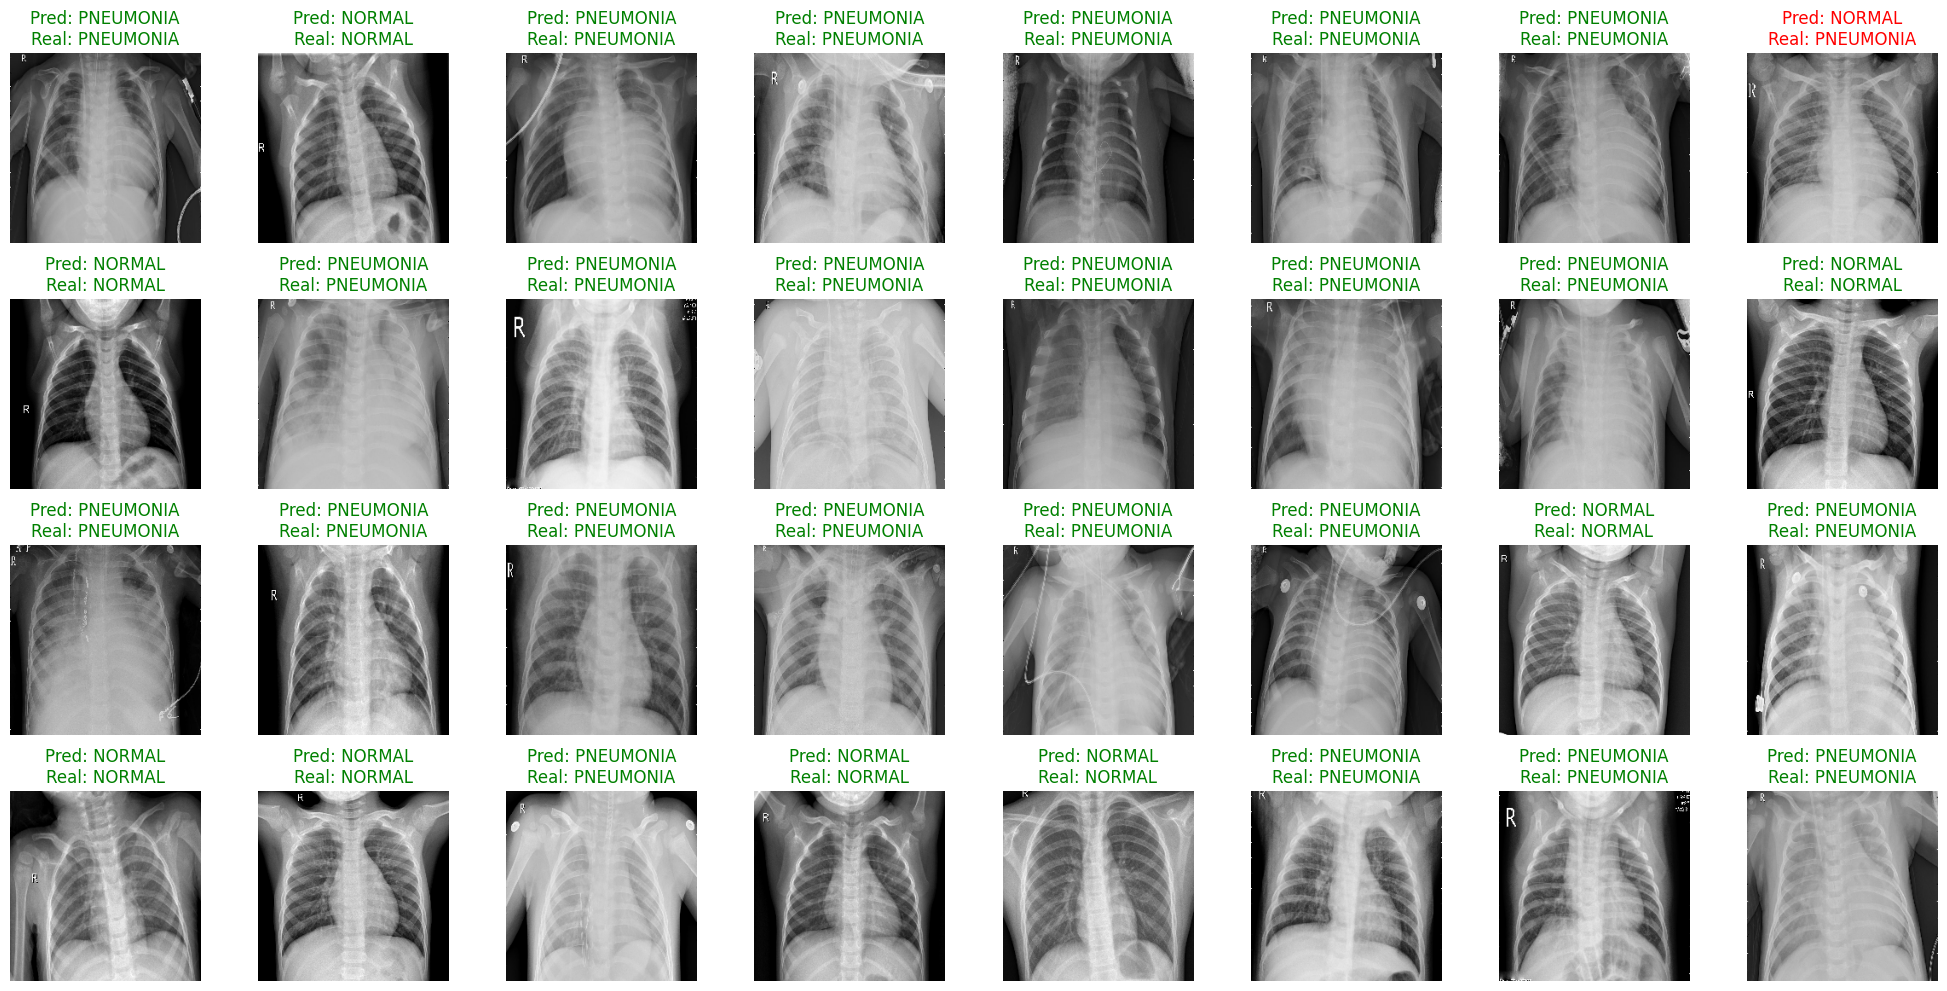

In [36]:
import matplotlib.pyplot as plt

images, labels = next(validation_generator)

predictions = model.predict(images)
predicted_labels = (predictions > 0.5).astype(int).flatten()

plt.figure(figsize=(20, 10))
for i in range(len(images)):
    plt.subplot(4, 8, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    color = 'green' if predicted_labels[i] == labels[i] else 'red'
    plt.title(f"Pred: {class_labels[predicted_labels[i]]}\nReal: {class_labels[int(labels[i])]}", color=color)
plt.tight_layout()
plt.show()